# YOLOv5 세그멘테이션 모델을 Comet과 연동하여 학습하기


## 1. Colab 환경 설정
먼저 Colab에서 필요한 패키지를 설치하고 YOLOv5 레포지토리를 클론합니다.

In [ ]:
# Comet.ml 설치
!pip install comet_ml

# YOLOv5 설치
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -qr requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 6.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 697.1/697.1 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 968.1/968.1 kB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 79.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 12.0 MB/s eta 0:00:00
  Created wheel for configobj: filename=configobj-5.0.9-py2.py3-none-any.whl size=35615 sha256=2eef7c1cb517fe2e64115c10b679382ce1d6e4f2b85d8a50a06b84d3c3414a02
  Stored in directory: /root/.cache/pip/wheels/a1/6c/03/6c5e3cf1a6e4b9e2fc5c4409be4abc5a8268bd9c878739cb32
Successfully built configobj
  Attempting uninstall: python-box
    Found existing installation: python-box 7.2.0
    Uninstalling python-box-7.2.0:
      Successfully uninstalled python-box-7.2.0

## 2. Comet API 및 Roboflow 데이터셋 설정

### 2.1 Comet Experiment 설정

Comet.ml을 사용하여 실험 과정을 추적합니다.

API 키는 보안상의 이유로 코드에 직접 포함하지 않는 것이 좋습니다. 대신 환경 변수를 사용합니다.

In [ ]:
from comet_ml import Experiment
from getpass import getpass

# Comet.ml 설정
api_key = getpass("Comet API 키를 입력하세요: ")
experiment = Experiment(
    api_key=api_key,
    project_name="yolov5-segmentation-tutorial",
    workspace="researcherhojin"
)

Comet API 키를 입력하세요: ··········


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/researcherhojin/yolov5-segmentation-tutorial/cfaf7306640146cbbb43015246c62541



### 2.2 Roboflow 데이터셋 다운로드 및 설정

Roboflow에서 Brain Tumor IS Dataset을 다운로드합니다. API 키는 노출되지 않도록 주의합니다.

In [ ]:
# 데이터셋 다운로드 및 압축 해제
!mkdir -p /content/yolov5/roboflow/Brain_Tumor_IS_Dataset

In [ ]:
# Roboflow 데이터셋 다운로드 및 압축 해제
!curl -L "https://universe.roboflow.com/ds/NWn5DEIACc?key=PEtdr2h8IV" > roboflow.zip
!unzip -o roboflow.zip -d /content/yolov5/roboflow/Brain_Tumor_IS_Dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   910  100   910    0     0   3044      0 --:--:-- --:--:-- --:--:--  3053
100 44.9M  100 44.9M    0     0  28.5M      0  0:00:01  0:00:01 --:--:-- 37.0M
Archive:  roboflow.zip
 extracting: /content/yolov5/roboflow/Brain_Tumor_IS_Dataset/README.dataset.txt  
 extracting: /content/yolov5/roboflow/Brain_Tumor_IS_Dataset/README.roboflow.txt  
 extracting: /content/yolov5/roboflow/Brain_Tumor_IS_Dataset/data.yaml  
   creating: /content/yolov5/roboflow/Brain_Tumor_IS_Dataset/test/
   creating: /content/yolov5/roboflow/Brain_Tumor_IS_Dataset/test/images/
 extracting: /content/yolov5/roboflow/Brain_Tumor_IS_Dataset/test/images/y701_jpg.rf.81a4472f77fdc1f31537342ceca340c9.jpg  
 extracting: /content/yolov5/roboflow/Brain_Tumor_IS_Dataset/test/images/y702_jpg.rf.bc09b4ae34c8da942f93ad0d60d6f05f.jpg  
 extracting: /content/yolov5/robof

In [ ]:
# 폴더 구조 확인
!ls /content/yolov5/roboflow/Brain_Tumor_IS_Dataset

data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid


In [ ]:
!ls /content/yolov5/roboflow/Brain_Tumor_IS_Dataset/train/images
!ls /content/yolov5/roboflow/Brain_Tumor_IS_Dataset/train/labels

y0_jpg.rf.8154234c0d164dd0c5ac932bfba37e44.jpg	  y325_jpg.rf.48dc70700063e48f4621c80691fccc23.jpg
y100_jpg.rf.96fb0368981857b55b794311b8ab7ba7.jpg  y326_jpg.rf.ca48e011a2e4c9be89534ea7ee4827e1.jpg
y101_jpg.rf.023437af27edb2804259f918cc5a4d84.jpg  y327_jpg.rf.15d6ad765dd2b623fba67b228f312fc4.jpg
y102_jpg.rf.38b85d866e47539af6d645eaec566a51.jpg  y328_jpg.rf.e626907ab636cce10e3e789d788a0dea.jpg
y103_jpg.rf.9591dc808af6603edb1662296fcbf5ef.jpg  y329_jpg.rf.0791bbc5fb825c76df88d1accda00551.jpg
y104_jpg.rf.bce41a9e54b7cebe8555fba31bc9ada6.jpg  y32_jpg.rf.220ae86d3be02ba0fd3882a1986653ef.jpg
y105_jpg.rf.8b931a0937bf45ed7d9f32dac48a0378.jpg  y330_jpg.rf.c6af56717893428cf8b7a78341c91175.jpg
y106_jpg.rf.aac70e3eec10001e986c32620f9c94bd.jpg  y331_jpg.rf.2d0345696df569e5b03168d0bbbe1f5c.jpg
y107_jpg.rf.d327ef97bfef315fc30749619f7270e5.jpg  y332_jpg.rf.3bd16491060d816bea3c55ee3387e0a1.jpg
y108_jpg.rf.6c0b9708efe12495054d39e1655f1c03.jpg  y333_jpg.rf.8f4dd1cdeff6168a3531de43275758b4.jpg
y109_jpg.rf.

### 2.3 데이터셋 설정 파일 작성 (data.yaml)

YOLOv5에서 사용할 데이터셋 설정 파일을 작성합니다.

In [ ]:
# data.yaml 파일 생성
dataset_yaml_content = """
train: /content/yolov5/roboflow/Brain_Tumor_IS_Dataset/train/images
val: /content/yolov5/roboflow/Brain_Tumor_IS_Dataset/valid/images
test: /content/yolov5/roboflow/Brain_Tumor_IS_Dataset/test/images

nc: 1  # 클래스 수 (여기서는 "Brain Tumor" 1개 클래스)
names: ["Brain Tumor"]
"""

with open('/content/yolov5/data.yaml', 'w') as file:
    file.write(dataset_yaml_content)

# data.yaml 내용 확인
!cat /content/yolov5/data.yaml


train: /content/yolov5/roboflow/Brain_Tumor_IS_Dataset/train/images
val: /content/yolov5/roboflow/Brain_Tumor_IS_Dataset/valid/images
test: /content/yolov5/roboflow/Brain_Tumor_IS_Dataset/test/images

nc: 1  # 클래스 수 (여기서는 "Brain Tumor" 1개 클래스)
names: ["Brain Tumor"]


## 3. YOLOv5 모델 구성 파일 수정
모델 구성 파일에서 nc 값을 데이터셋의 클래스 수에 맞게 변경합니다.

이 설정이 올바르게 되어 있어야 정확한 클래스 분류가 가능합니다.


### 3.1 모델 구성 파일 수정 (yolov5n-seg.yaml)
yolov5n-seg.yaml 파일을 수정하여 nc 값을 1로 설정합니다.

In [ ]:
# 1. 먼저 현재 사용 가능한 모델 설정 파일들을 확인
!ls /content/yolov5/models/segment/

yolov5l-seg.yaml  yolov5m-seg.yaml  yolov5n-seg.yaml  yolov5s-seg.yaml	yolov5x-seg.yaml


In [ ]:
# 2. yolov5n-seg.yaml 파일을 수정 (현재 보고 계신 파일)
with open('/content/yolov5/models/segment/yolov5n-seg.yaml', 'r') as f:
    config = f.read()

# 정규 표현식을 사용하여 더 정확하게 nc 값을 변경
import re
config = re.sub(r'nc: \d+', 'nc: 1', config)

with open('/content/yolov5/models/segment/yolov5n-seg.yaml', 'w') as f:
    f.write(config)

# 변경 확인
print("수정된 파일 내용:")
!cat /content/yolov5/models/segment/yolov5n-seg.yaml | head -n 5

수정된 파일 내용:
# Ultralytics YOLOv5 🚀, AGPL-3.0 license

# Parameters
nc: 1 # number of classes
depth_multiple: 0.33 # model depth multiple


## 4. 학습 실행 코드 작성

이제 YOLOv5를 사용하여 세그멘테이션 학습을 시작할 수 있습니다.

### 4.1 Wandb 비활성화

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"  # wandb 비활성화

### 4.2 학습 시작
YOLOv5 세그멘테이션 모델을 학습합니다.

In [ ]:
%%time
%cd /content/yolov5/

!python segment/train.py \
    --epochs 10 \
    --batch-size 16 \
    --data /content/yolov5/data.yaml \
    --weights yolov5s-seg.pt \
    --cfg models/segment/yolov5s-seg.yaml \
    --project runs/train \
    --name brain_tumor_segmentation \
    --cache

/content/yolov5
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2024-11-01 08:33:07.613506: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-01 08:33:07.644643: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-01 08:33:07.655044: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452

## 5. 학습 결과 확인 및 평가

학습이 완료되면 YOLOv5의 결과 파일과 Comet 대시보드를 통해 학습 과정과 결과를 확인할 수 있습니다.

### 5.1 학습 결과 파일 확인

In [ ]:
# 학습 결과 파일 목록 확인
!ls runs/train/brain_tumor_segmentation

BoxF1_curve.png					    labels.jpg	      train_batch0.jpg
BoxP_curve.png					    MaskF1_curve.png  train_batch1.jpg
BoxPR_curve.png					    MaskP_curve.png   train_batch2.jpg
BoxR_curve.png					    MaskPR_curve.png  val_batch0_pred.jpg
confusion_matrix.png				    MaskR_curve.png   val_batch1_pred.jpg
events.out.tfevents.1730449991.37339f486c56.1371.0  opt.yaml	      val_batch2_labels.jpg
hyp.yaml					    results.csv       val_batch2_pred.jpg
labels_correlogram.jpg				    results.png       weights


### 5.2 학습 결과 시각화

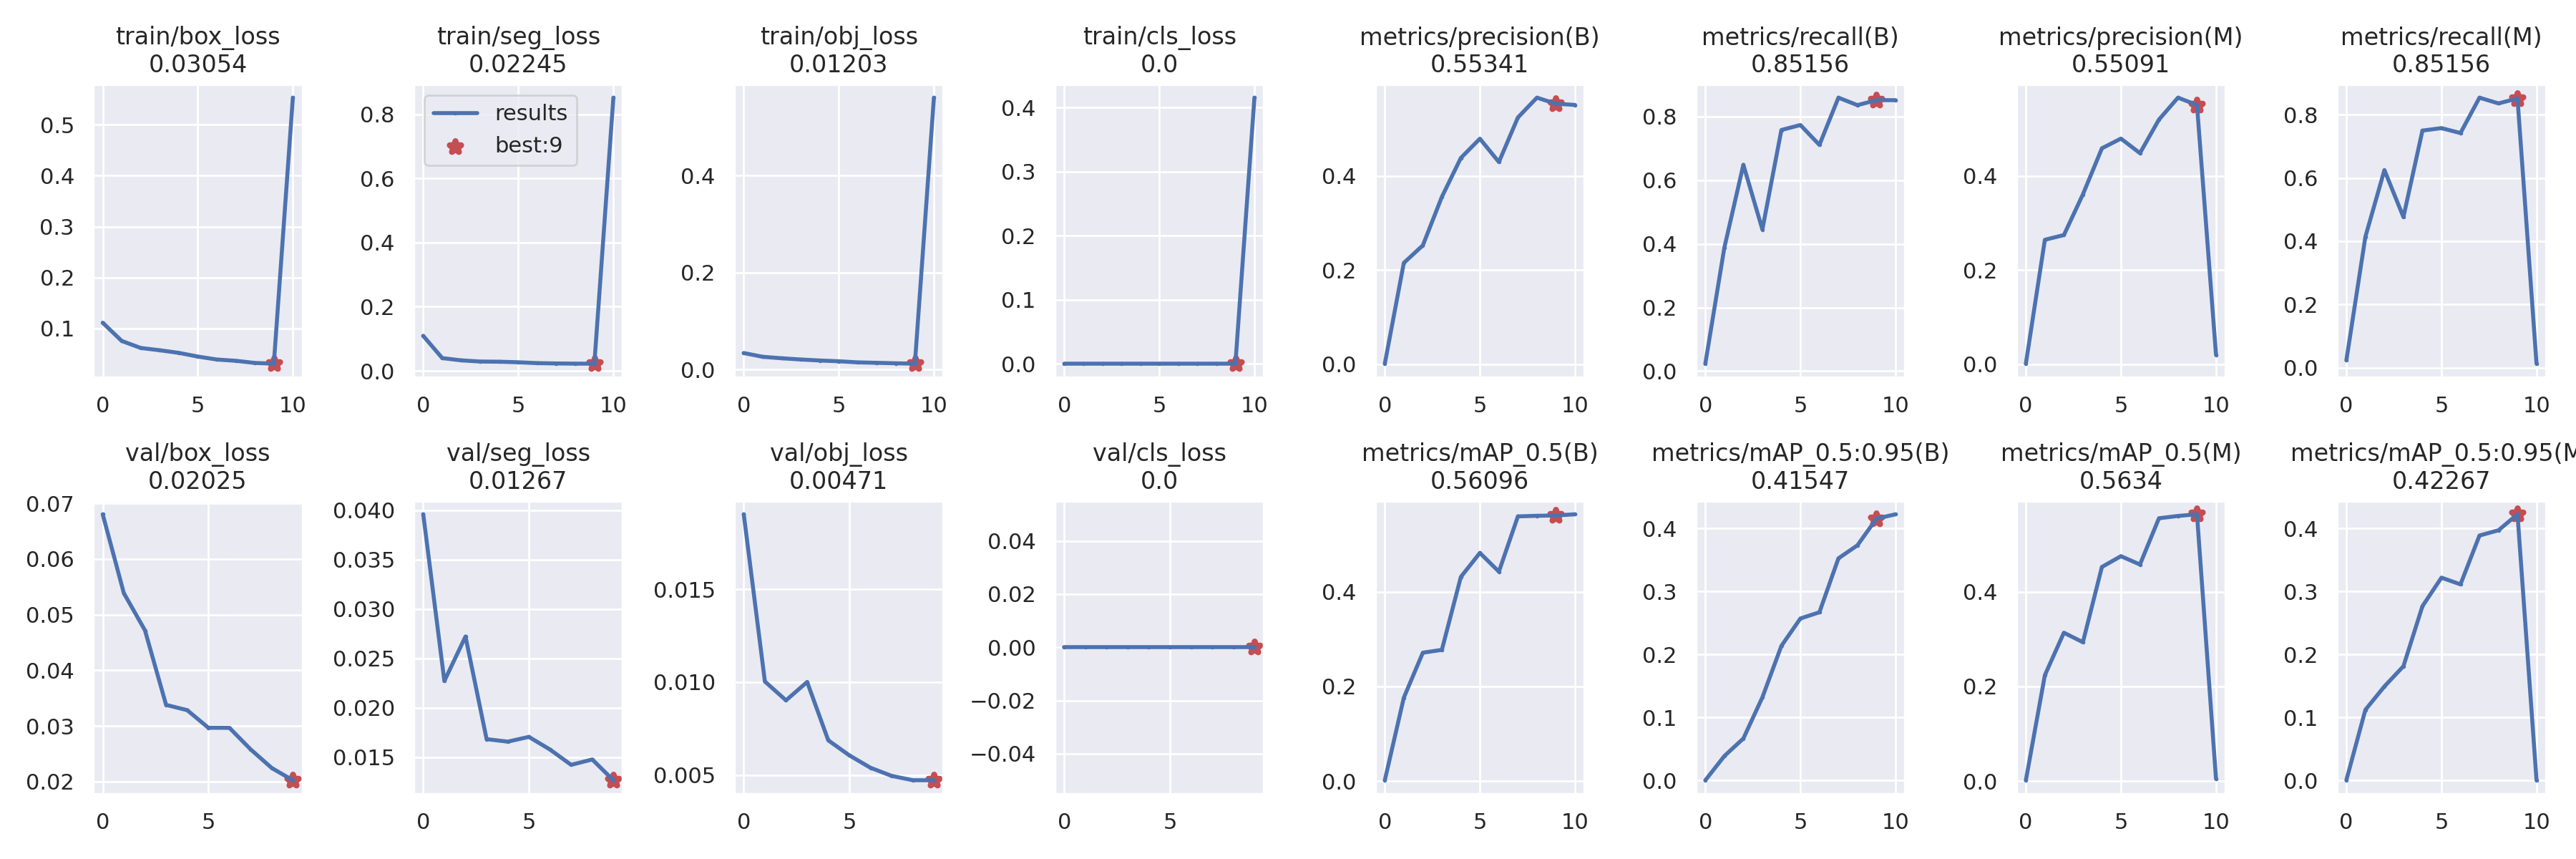

In [ ]:
from IPython.display import Image, display

# 결과 그래프 시각화
result_image_path = "runs/train/brain_tumor_segmentation/results.png"
display(Image(filename=result_image_path))

## 6. 검증 및 테스트 결과 확인

검증 (Validation) 결과 확인: 검증 데이터셋에 대해 모델의 성능을 평가하고 결과를 시각화합니다.

### 6.1 검증 데이터셋에서 모델 평가

In [ ]:
!python segment/val.py \
    --data data.yaml \
    --weights runs/train/brain_tumor_segmentation/weights/best.pt \
    --project runs/val \
    --name brain_tumor_segmentation_val \
    --save-conf

segment/val: data=data.yaml, weights=['runs/train/brain_tumor_segmentation/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=True, save_json=False, project=runs/val, name=brain_tumor_segmentation_val, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-378-g2f74455a Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s-seg summary: 165 layers, 7398422 parameters, 0 gradients, 25.7 GFLOPs
val: Scanning /content/yolov5/roboflow/Brain_Tumor_IS_Dataset/valid/labels.cache... 201 images, 74 backgrounds, 0 corrupt: 100% 201/201 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% 7/7 [00:09<00:00,  1.41s/it]
                   all        201        128      0.553      0.852      0.561      0.417  

### 6.2 테스트 데이터셋 평가

In [ ]:
!python segment/val.py \
    --data data.yaml \
    --weights runs/train/brain_tumor_segmentation/weights/best.pt \
    --project runs/test \
    --name brain_tumor_segmentation_test \
    --task test \
    --save-conf

segment/val: data=data.yaml, weights=['runs/train/brain_tumor_segmentation/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=True, save_json=False, project=runs/test, name=brain_tumor_segmentation_test, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-378-g2f74455a Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s-seg summary: 165 layers, 7398422 parameters, 0 gradients, 25.7 GFLOPs
test: Scanning /content/yolov5/roboflow/Brain_Tumor_IS_Dataset/test/labels... 100 images, 43 backgrounds, 0 corrupt: 100% 100/100 [00:00<00:00, 592.22it/s]
test: New cache created: /content/yolov5/roboflow/Brain_Tumor_IS_Dataset/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% 4/4 [00:06<00:00,  1.7

### 6.3 결과 시각화

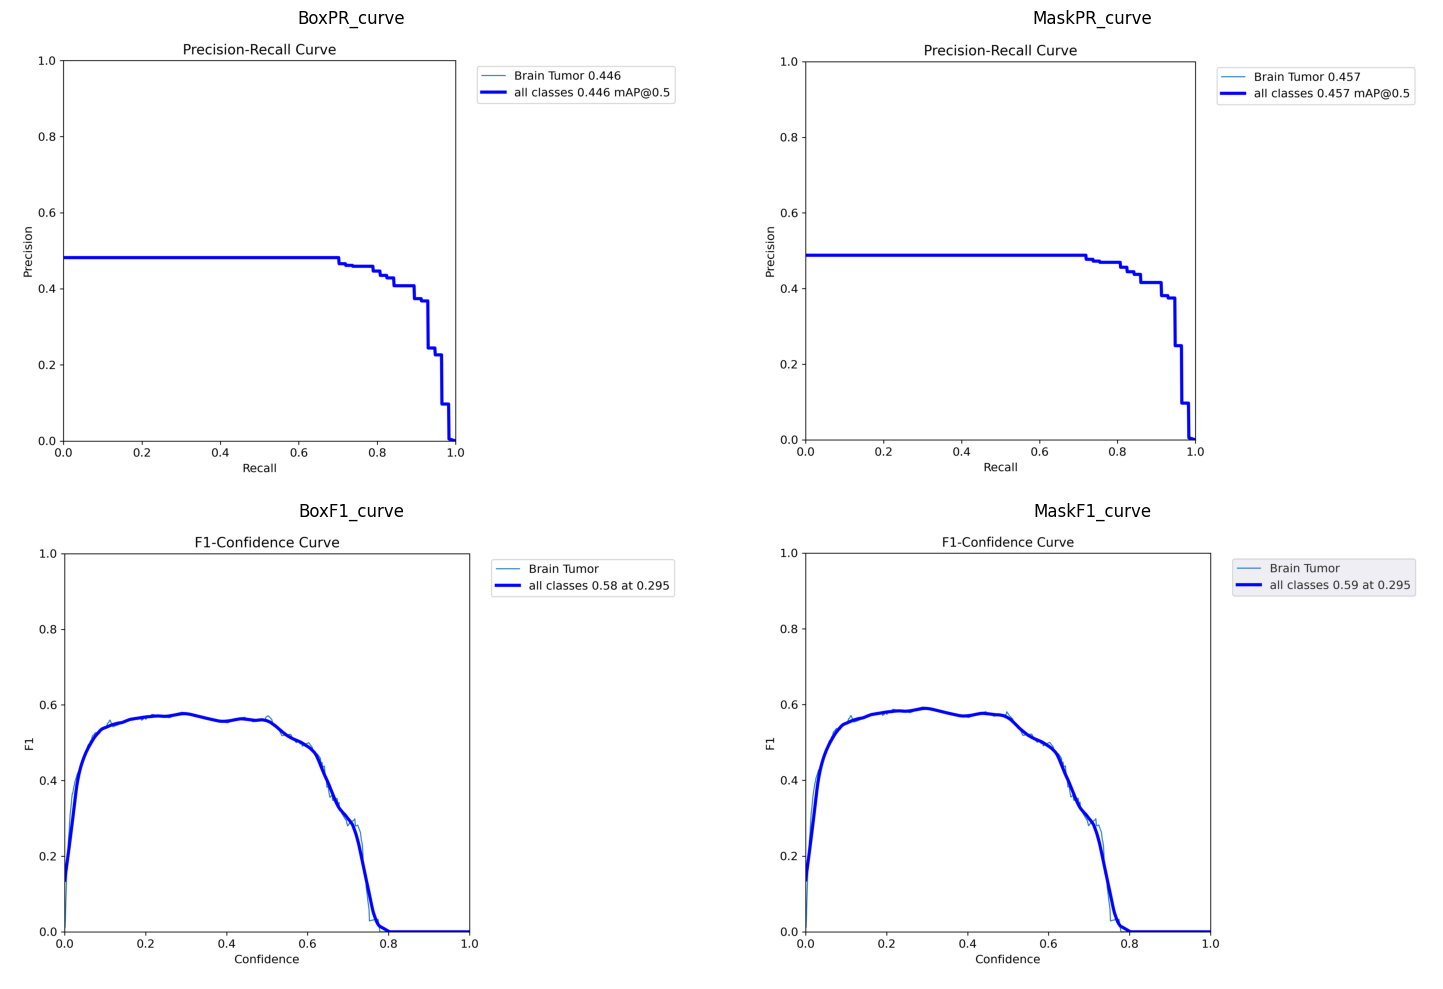

In [ ]:
import matplotlib.pyplot as plt

def plot_results(results_dir):
    """결과 이미지 시각화"""
    metrics = ['BoxPR_curve.png', 'MaskPR_curve.png',
              'BoxF1_curve.png', 'MaskF1_curve.png']

    plt.figure(figsize=(15, 10))
    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 2, i)
        img = plt.imread(f'{results_dir}/{metric}')
        plt.imshow(img)
        plt.axis('off')
        plt.title(metric.split('.')[0])
    plt.tight_layout()
    plt.show()

# 테스트 결과 시각화
plot_results('runs/test/brain_tumor_segmentation_test')

In [ ]:
!python segment/val.py \
    --weights runs/train/brain_tumor_segmentation/weights/best.pt \
    --data data.yaml \
    --task test \
    --project runs/test \
    --name brain_tumor_test \
    --save-conf \
    --img 640    # 이미지 크기 명시

segment/val: data=data.yaml, weights=['runs/train/brain_tumor_segmentation/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=True, save_json=False, project=runs/test, name=brain_tumor_test, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-378-g2f74455a Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s-seg summary: 165 layers, 7398422 parameters, 0 gradients, 25.7 GFLOPs
test: Scanning /content/yolov5/roboflow/Brain_Tumor_IS_Dataset/test/labels.cache... 100 images, 43 backgrounds, 0 corrupt: 100% 100/100 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% 4/4 [00:05<00:00,  1.38s/it]
                   all        100         57      0.445      0.789      0.446      0.299      0.455 

In [ ]:
# 학습된 모델 파일 존재 확인
!ls -l runs/train/brain_tumor_segmentation/weights/best.pt

-rw-r--r-- 1 root root 15221582 Nov  1 08:36 runs/train/brain_tumor_segmentation/weights/best.pt


In [ ]:
!ls -R runs/test/brain_tumor_test2

runs/test/brain_tumor_test2:
BoxF1_curve.png  confusion_matrix.png  MaskR_curve.png	      val_batch1_pred.jpg
BoxP_curve.png	 MaskF1_curve.png      val_batch0_labels.jpg  val_batch2_labels.jpg
BoxPR_curve.png  MaskP_curve.png       val_batch0_pred.jpg    val_batch2_pred.jpg
BoxR_curve.png	 MaskPR_curve.png      val_batch1_labels.jpg


In [ ]:
# 단일 이미지에 대한 테스트
!python segment/predict.py \
    --weights runs/train/brain_tumor_segmentation/weights/best.pt \
    --source /content/yolov5/roboflow/Brain_Tumor_IS_Dataset/test/images \
    --save-txt \
    --save-conf

segment/predict: weights=['runs/train/brain_tumor_segmentation/weights/best.pt'], source=/content/yolov5/roboflow/Brain_Tumor_IS_Dataset/test/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/predict-seg, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1, retina_masks=False
YOLOv5 🚀 v7.0-378-g2f74455a Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s-seg summary: 165 layers, 7398422 parameters, 0 gradients, 25.7 GFLOPs
WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/100 /content/yolov5/roboflow/Brain_Tumor_IS_Dataset/test/images/y701_jpg.rf.81a4472f77fdc1f31537342ceca340c9.jpg: 640x640 1 Brain Tumor, 14.7ms
image 2/100 /content/yolov5/roboflow/Brain_Tumor_IS_

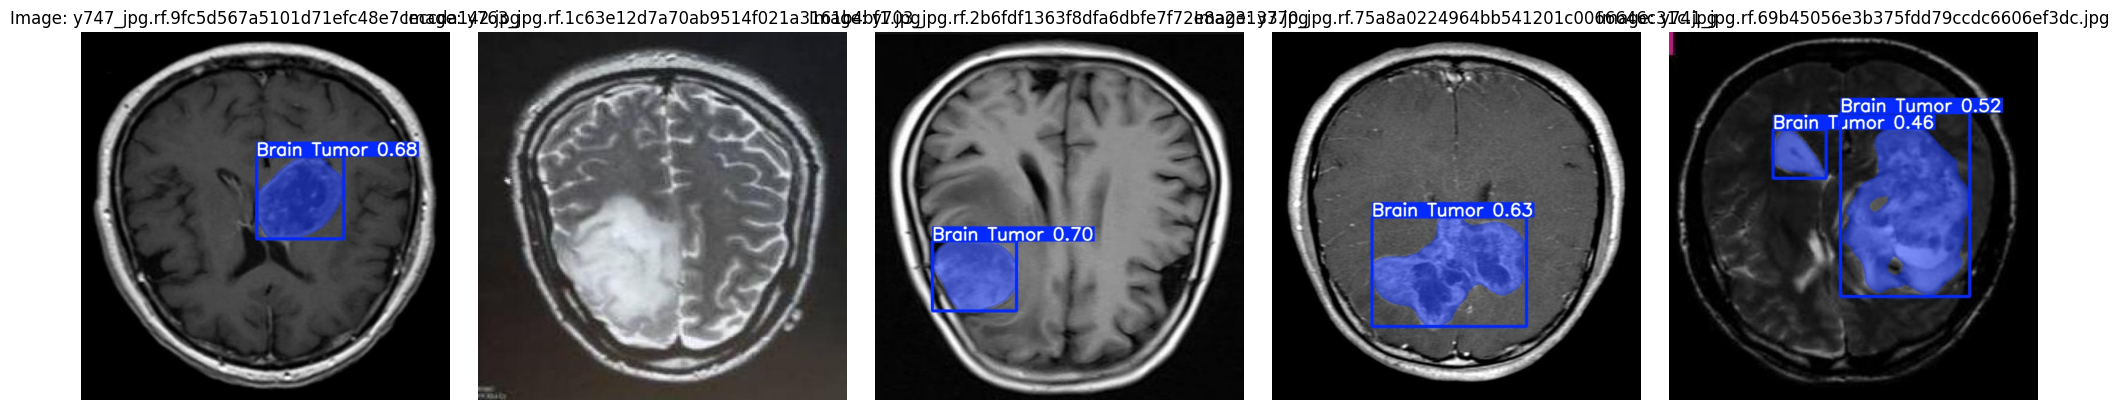


선택된 이미지 파일:
- runs/predict-seg/exp/y747_jpg.rf.9fc5d567a5101d71efc48e7ceccda142.jpg
- runs/predict-seg/exp/y763_jpg.rf.1c63e12d7a70ab9514f021a3161b4bf1.jpg
- runs/predict-seg/exp/y703_jpg.rf.2b6fdf1363f8dfa6dbfe7f72e8a23133.jpg
- runs/predict-seg/exp/y770_jpg.rf.75a8a0224964bb541201c0066646c31c.jpg
- runs/predict-seg/exp/y741_jpg.rf.69b45056e3b375fdd79ccdc6606ef3dc.jpg


In [ ]:
import random
import matplotlib.pyplot as plt
from PIL import Image
import glob

def visualize_random_predictions():
    # 예측 결과가 저장된 디렉토리에서 이미지 가져오기
    pred_path = 'runs/predict-seg/exp'
    pred_images = glob.glob(f'{pred_path}/*.jpg')

    # 5개 랜덤 선택
    random_images = random.sample(pred_images, 5)

    # 시각화
    plt.figure(figsize=(20, 4))
    for idx, img_path in enumerate(random_images):
        # 이미지 로드
        img = Image.open(img_path)

        # 서브플롯 생성
        plt.subplot(1, 5, idx + 1)
        plt.imshow(img)
        plt.axis('off')

        # 파일명에서 이미지 ID 추출
        img_id = img_path.split('/')[-1]
        plt.title(f'Image: {img_id}')

    plt.tight_layout()
    plt.show()

    # 선택된 이미지들의 파일명 출력
    print("\n선택된 이미지 파일:")
    for img_path in random_images:
        print(f"- {img_path}")

# 시각화 실행
visualize_random_predictions()